In [ ]:
# @title Adding required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np



- **Problem Statement**
Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*** - Transfer Learning***

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.

I will be using the the epynomously named VGG network. Specifically, I'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers).

In [ ]:
model=models.vgg19(pretrained=True).features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
my_features_layers=['0','5','10','19','28']

In [ ]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG,self).__init__()
    self.chosen_features=my_features_layers
    self.model=models.vgg19(pretrained=True).features[:29]

  def forward(self,x):
    features=[]
    for layer_num,layer in enumerate(self.model):
      x=layer(x)

      if str(layer_num) in self.chosen_features:
        features.append(x)

    return features




In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
image_size=356

In [ ]:
loader=transforms.Compose(
   [ transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
   ]
)

In [ ]:
def load_image(image_path):
  image=Image.open(image_path)
  image=loader(image).unsqueeze(0)
  return image.to(device)

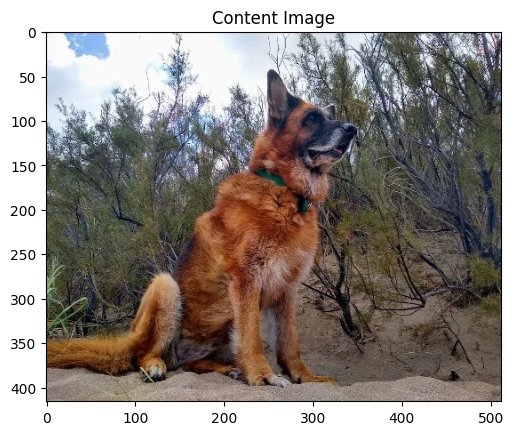

In [ ]:
original_image_path="/content/drive/MyDrive/Colab Notebooks/kescutai/dashtoon/content.jpeg"

img = Image.open(original_image_path)
plt.imshow(img)
plt.title('Content Image')
plt.show()

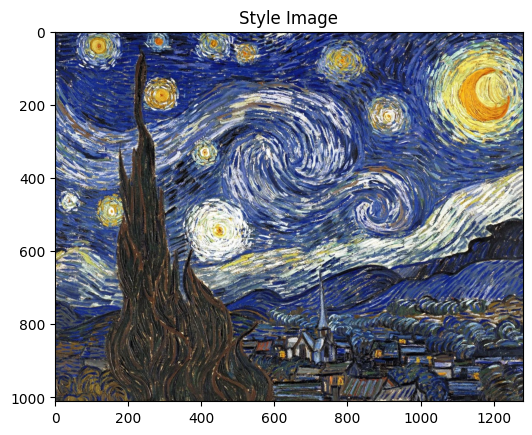

In [ ]:
style_image_path="/content/drive/MyDrive/Colab Notebooks/kescutai/dashtoon/style.jpg"

img = Image.open(style_image_path)
plt.imshow(img)
plt.title('Style Image')
plt.show()

In [ ]:
original_image=load_image(original_image_path)
style_image=load_image(style_image_path)

In [ ]:
print(original_image.shape)

torch.Size([1, 3, 356, 356])


In [ ]:
model=VGG().to(device).eval()

#3.Parameter
Most of the  optimize a cost function to get a set of parameter values. With Neural Style Transfer, I'll get to optimize a cost function to get pixel values.

In [ ]:
generated_image=original_image.clone().requires_grad_(True) #parameter

In [ ]:
total_steps=600
learning_rate=0.01
optimizer=optim.Adam([generated_image],lr=learning_rate)
alpha=1
beta=0.01
print_interval=200

#4 - Loss Function
Next, I will design the Neural Style Transfer (NST) algorithm in three steps:

First, I will build the content cost function =Jcontent (C,G)

Second, I will build the style cost function  =Jstyle (S, G)

Finally, I put it all together to get final loss=  J(G) = alpa * J content (C, G) + Beta * Jstyle (S, G) where x=multiply sign


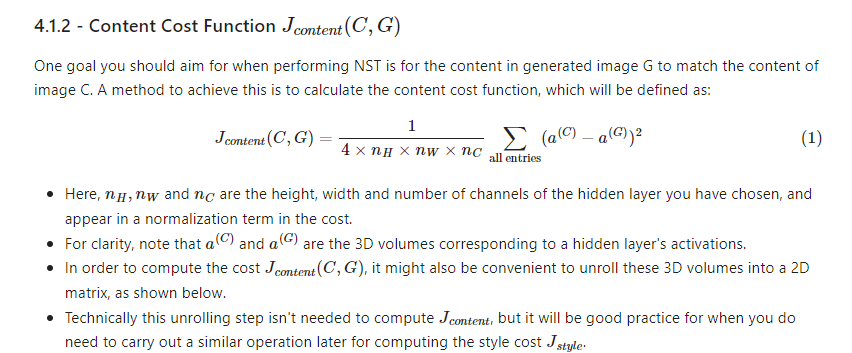

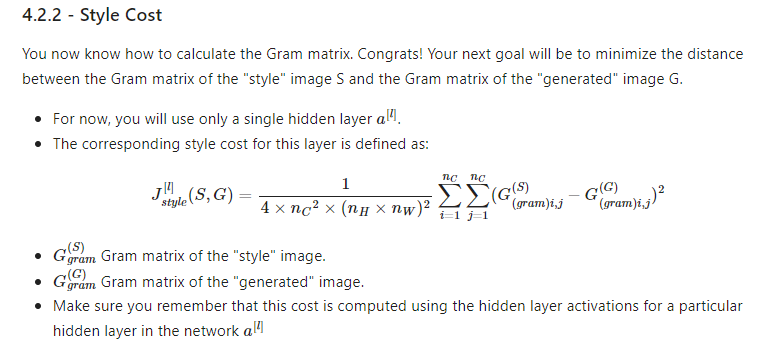

In [ ]:
content_lossx=[]
style_lossx=[]
total_lossx=[]
num_epoch=[]

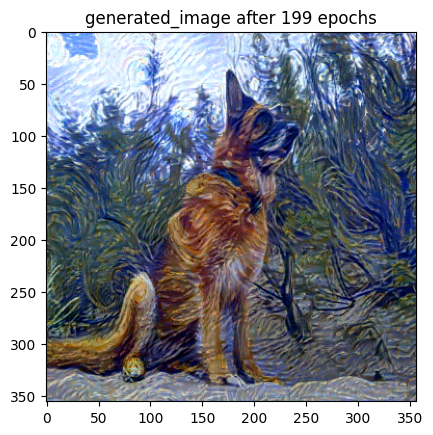

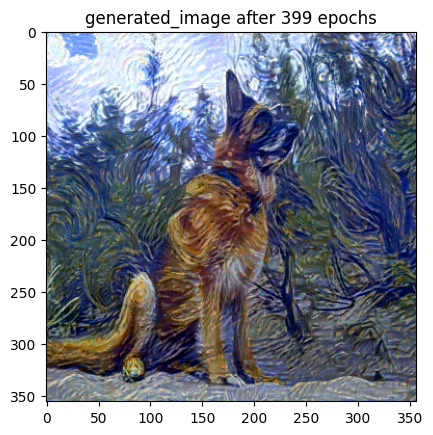

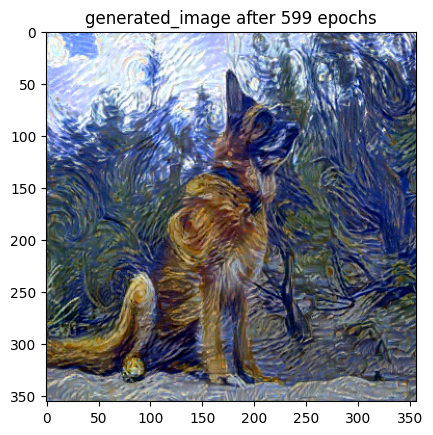

In [ ]:
for step in range(total_steps):
  generated_features=model(generated_image)
  original_features=model(original_image)
  style_features=model(style_image)
  style_loss=content_loss=0;
  for gen_feature,orig_feature,style_feature in zip(
      generated_features,original_features,style_features):
    batch_size,channel,height,width=gen_feature.shape
    content_loss+=torch.mean((gen_feature-orig_feature)**2)

    ##compute gram matrix
    G=gen_feature.view(channel,height*width).mm(
        gen_feature.view(channel,height*width).t()
    )
    A=style_feature.view(channel,height*width).mm(
        style_feature.view(channel,height*width).t()
    )

    style_loss+=torch.mean((G-A)**2)
  total_loss=alpha*content_loss+beta*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
    # Print generated image every 300 steps
  if (step+1)%200 ==0:
    num_epoch.append(step)
    content_lossx.append(content_loss)
    style_lossx.append(style_loss)
    total_lossx.append(total_loss)
  if (step + 1) % print_interval == 0:
    image_array = generated_image.cpu().detach().numpy()
    # Transpose the array to match the shape expected by imshow
    image_array = np.transpose(image_array, (0, 2, 3, 1))
    # Display the image
    plt.imshow(image_array.squeeze())
    plt.title(f'generated_image after {step} epochs')  # Optional: Turn off axis labels
    plt.show()



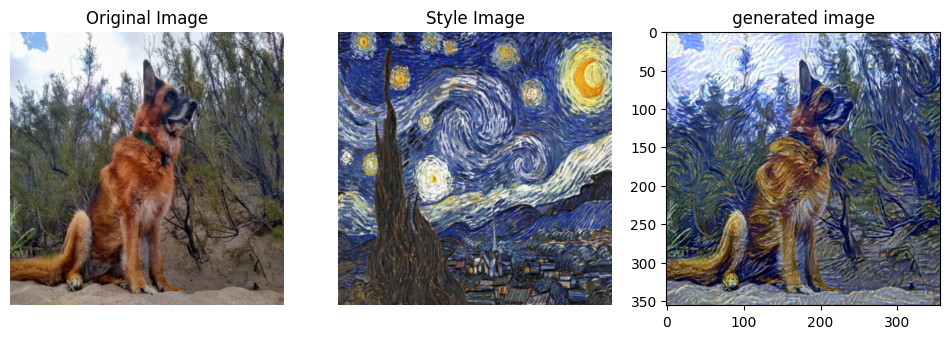

In [ ]:
image_array = generated_image.cpu().detach().numpy()

# Transpose the array to match the shape expected by imshow
image_array = np.transpose(image_array, (0, 2, 3, 1))

unloader = transforms.ToPILImage()
plt.figure(figsize=(12, 12))
# Display the original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(unloader(original_image.squeeze(0)))
plt.axis('off')

# Display the style image
plt.subplot(1, 3, 2)
plt.title('Style Image')
plt.imshow(unloader(style_image.squeeze(0)))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(image_array.squeeze())
plt.title(' generated image ')  # Optional: Turn off axis labels
# Show the images
plt.show()
# Display the image
# plt.imshow(image_array.squeeze())
# plt.title(' generated image ')  # Optional: Turn off axis labels
# plt.show()

In [ ]:
content_lossx = [item.item() for item in content_lossx]

In [ ]:
# plt.plot(num_epoch, content_lossx, marker='o', linestyle='-')

# # Adding labels and title
# plt.xlabel('number of epochs')
# plt.ylabel('content_loss')
# plt.title('content loss and epochs')